# Astrometric distortion

This notebook plots the astrometric distortion of one FPA simulation by comparing a non corrected image and a corrected image.

In [1]:
# Do all boring imports
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib
from matplotlib.pylab import griddata
import matplotlib.pyplot as plt

%matplotlib inline

Create an image with no distortions fixed and the reference point in the center of the focal plane.

In [2]:
import wcsfit
wcsfit.merge_quadrants('simone.fits', append="_nofix_ccd")

wcsfit:INFO:merging quadrants into CCD image (simone.fits)
wcsfit:INFO:output image already exists simone_nofix_ccd.fits


Open the FITS files

In [3]:
img = fits.open('simone_ccd.fits')
img_nofix = fits.open('simone_nofix_ccd.fits')

Create a grid by looping for each chip and computing the coordinates and the distortion.

In [4]:
refra = np.array([])
refdec=np.array([])
deltara=np.array([])
deltadec=np.array([])
for ccdno in range(1,37):
    w = WCS(img[ccdno].header)
    w_nofix = WCS(img_nofix[ccdno].header)
    
    x, y = np.meshgrid(np.arange(1, w.wcs.crpix[0]*2, 100), np.arange(1, w.wcs.crpix[1]*2, 100))
    x, y = x.flatten(), y.flatten()

    ra, dec = w_nofix.wcs_pix2world(x, y, 1)
    trefra, trefdec = w.wcs_pix2world(x, y, 1)
    
    refra = np.concatenate((refra, trefra))
    refdec = np.concatenate((refdec, trefdec))
    deltara = np.concatenate((deltara, (ra-trefra)*3600.0))
    deltadec = np.concatenate((deltadec, (dec-trefdec)*3600.0))
    

Refer all coordinates to a single chip (in this case 6) for easy plotting.

In [5]:
ccdno=6
w_nofix = WCS(img_nofix[ccdno].header)
x, y = w_nofix.wcs_world2pix(refra, refdec, 1)

xi = w_nofix.wcs.cd[0][0]*(x - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[0][1]*(y - w_nofix.wcs.crpix[1])
eta = w_nofix.wcs.cd[1][0]*(x - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[1][1]*(y - w_nofix.wcs.crpix[1])

And compute the grid.

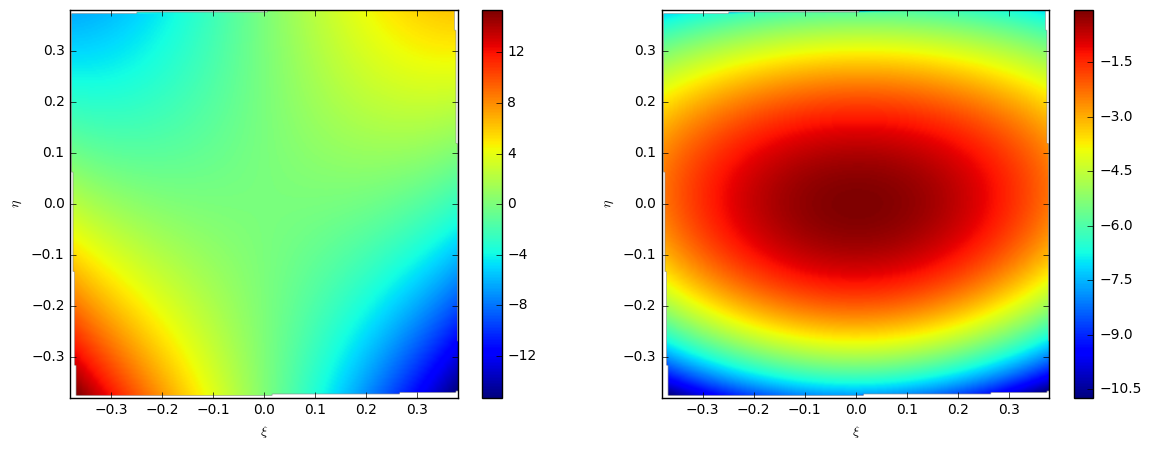

In [16]:
xs, ys = np.meshgrid(np.arange(x.min(), x.max(), 100), np.arange(y.min(), y.max(), 100))
xis = w_nofix.wcs.cd[0][0]*(xs - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[0][1]*(ys - w_nofix.wcs.crpix[1])
etas = w_nofix.wcs.cd[1][0]*(xs - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[1][1]*(ys - w_nofix.wcs.crpix[1])

fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
resra = griddata(xi, eta, deltara, xis, etas, interp='linear')
im = plt.imshow(resra.T.transpose(), extent=(-0.38, 0.38, -0.38, 0.38), origin='lower')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\eta$')
_ = plt.colorbar()

plt.subplot(1,2,2)
resdec = griddata(xi, eta, deltadec, xis, etas, interp='linear')
im = plt.imshow(resdec.T.transpose(), extent=(-0.38, 0.38, -0.38, 0.38), origin='lower')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\eta$')
_ = plt.colorbar()

data={'deltara': resra.T.transpose(), 'deltadec': resdec.T.transpose()}


To compute the arrow diagram we do the same but use a larger grid step.

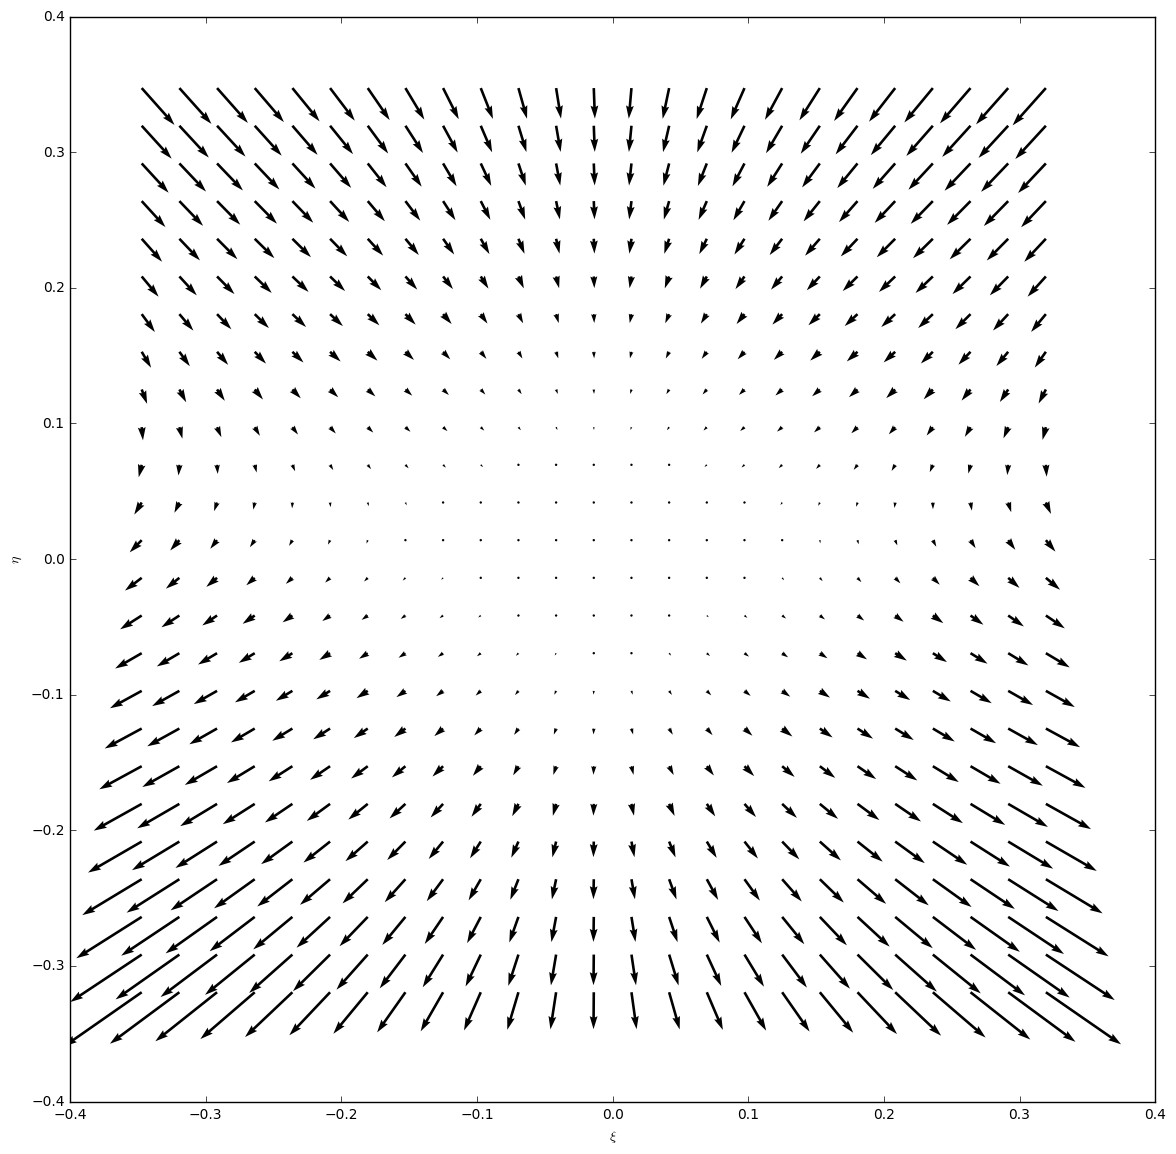

In [12]:
xs, ys = np.meshgrid(np.arange(x.min(), x.max(), 1000), np.arange(y.min(), y.max(), 1000))
xis = w_nofix.wcs.cd[0][0]*(xs - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[0][1]*(ys - w_nofix.wcs.crpix[1])
etas = w_nofix.wcs.cd[1][0]*(xs - w_nofix.wcs.crpix[0]) + w_nofix.wcs.cd[1][1]*(ys - w_nofix.wcs.crpix[1])

resra = griddata(x, y, deltara, xs, ys, interp='linear')
resdec = griddata(x, y, deltadec, xs, ys, interp='linear')

d1 = resra.flatten()
d2 = resdec.flatten()

plt.figure(figsize=(14,14))
plt.quiver((xis-np.median(xis)), etas-np.median(etas), d1, d2)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\eta$')
_ = 1

In [17]:
# Save as pickle
import pickle


pickle.dump(data, open('save.p', 'wb'))